In [31]:
%matplotlib inline
from __future__ import print_function
import argparse
import sys
import chainer
import chainer.functions as F
import chainer.links as L
import numpy as np
import matplotlib.pyplot as plt
from chainer import Variable
from chainer import cuda
from chainer import training
from chainer.training import extensions
from sklearn.datasets import fetch_mldata

## Network definition

In [2]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__(
            # the size of the inputs to each layer will be inferred
            l1=L.Linear(None, n_units),  # n_in -> n_units
            l2=L.Linear(None, n_units),  # n_units -> n_units
            l3=L.Linear(None, n_out),  # n_units -> n_out
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

### パラメータ

In [3]:
# 確率的勾配降下法で学習させる際の１回分のバッチサイズ
batchsize = 100
# 学習の繰り返し回数
n_epoch   = 20
# 中間層の数
n_units   = 1000
# 出力層の数
n_out = 10

### モデルを作る

In [4]:
# Set up a neural network to train
# Classifier reports softmax cross entropy loss and accuracy at every
# iteration, which will be used by the PrintReport extension below.
model = L.Classifier(MLP(n_units, n_out))

### MNISTデータロード
- mnist.data : 70,000件の784次元ベクトルデータ
- mnist.target : 正解データ（教師データ)

In [6]:
mnist = fetch_mldata('MNIST original')
mnist.data   = mnist.data.astype(np.float32)

In [7]:
mnist.data.shape

(70000, 784)

In [8]:
mnist.data[0][0:300]

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,   51.,

In [9]:
mnist.data  /= 255     # 0-1のデータに変換

In [10]:
mnist.target = mnist.target.astype(np.int32)

In [11]:
mnist.target.shape

(70000,)

In [12]:
mnist.target

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

### 学習用データを N個、検証用データを残りの個数と設定


In [13]:
N = 60000
x_train, x_test = np.split(mnist.data,   [N])
y_train, y_test = np.split(mnist.target, [N])
N_test = y_test.size

In [14]:
(N,N_test)

(60000, 10000)

### Variable のテスト

In [15]:
x_data = np.array([1,2,3,4,5,6], dtype=np.float32)
x = Variable(x_data)
x

### dropout(x, ratio=0.5, train=True) テスト
- x: 入力値
- ratio: 0を出力する確率
- train: Falseの場合はxをそのまま返却する
- return: ratioの確率で0を、1−ratioの確率で,x*(1/(1-ratio))の値を返す

In [16]:
n = 50
v_sum = 0
for i in range(n):
    x_data = np.array([1,2,3,4,5,6], dtype=np.float32)
    x = Variable(x_data)
    dr = F.dropout(x, ratio=0.6,train=True)

    for j in range(6):
        sys.stdout.write( str(dr.data[j]) + ', ' )
    print("")
    v_sum += dr.data

0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 
0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 
2.5, 5.0, 0.0, 0.0, 0.0, 0.0, 
2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 
0.0, 0.0, 7.5, 10.0, 0.0, 15.0, 
2.5, 0.0, 0.0, 10.0, 0.0, 0.0, 
0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
0.0, 5.0, 0.0, 10.0, 12.5, 15.0, 
0.0, 5.0, 0.0, 0.0, 12.5, 15.0, 
0.0, 5.0, 0.0, 0.0, 12.5, 15.0, 
2.5, 0.0, 0.0, 0.0, 12.5, 0.0, 
0.0, 0.0, 0.0, 10.0, 12.5, 0.0, 
2.5, 5.0, 0.0, 0.0, 0.0, 0.0, 
0.0, 5.0, 0.0, 10.0, 0.0, 0.0, 
0.0, 5.0, 0.0, 0.0, 12.5, 15.0, 
0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 
2.5, 0.0, 7.5, 0.0, 0.0, 0.0, 
0.0, 0.0, 7.5, 10.0, 0.0, 15.0, 
2.5, 5.0, 0.0, 0.0, 0.0, 0.0, 
0.0, 0.0, 7.5, 10.0, 0.0, 0.0, 
0.0, 0.0, 7.5, 10.0, 0.0, 15.0, 
2.5, 5.0, 0.0, 10.0, 0.0, 0.0, 
2.5, 5.0, 0.0, 0.0, 0.0, 15.0, 
0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 
0.0, 0.0, 7.5, 10.0, 0.0, 15.0, 
2.5, 0.0, 7.5, 0.0, 12.5, 0.0, 
0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 
2.5, 0.0, 7.5, 10.0, 0.0, 0.0, 
0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 
0.0, 0.0, 7.5, 10.0, 12.5, 15.0, 
0.0, 0.0, 7.5, 0.0, 12.5, 0.0, 
0.0, 0

outputの平均がx_dataとだいたい一致する

In [17]:
sys.stdout.write( str((v_sum/float(n))) )

[ 1.          1.60000002  2.8499999   4.4000001   4.          6.        ]

ratio=0.6を設定しているので、

60%の確率でドロップアウトされ、0が出力される。

40%の確率で値が返されるが、値を返す確率が40%に減ってしまっているのを補うために1 / 0.4 = 2.5倍 された値が出力される。

結果、平均が元のデータと一致するという感じらしい

### 学習

### モデル設定
- 多層パーセプトロンモデルの設定
- 入力 784次元、出力 10次元

In [25]:
model = chainer.FunctionSet(
    l1=F.Linear(784, n_units),
    l2=F.Linear(n_units, n_units),
    l3=F.Linear(n_units, 10)
)

### Setup optimizer

In [26]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

### ニューラルネットの構造

In [27]:
def forward(x_data, y_data, train=True):
    x, t = Variable(x_data), Variable(y_data)
    h1 = F.dropout(F.relu(model.l1(x)),  train=train)
    h2 = F.dropout(F.relu(model.l2(h1)), train=train)
    y  = model.l3(h2)
    # 多クラス分類なので誤差関数としてソフトマックス関数の交差エントロピー関数を用いて、誤差を導出
    return F.softmax_cross_entropy(y, t), F.accuracy(y, t)

### フィードフォワードニューラルネットワーク

In [34]:
train_loss = []
train_acc  = []
test_loss = []
test_acc  = []
l1_W = []
l2_W = []
l3_W = []

In [35]:
# Learning loop
for epoch in range(1, n_epoch+1):
    print('epoch: {}'.format(epoch))

    # training
    # N個の順番をランダムに並び替える
    perm = np.random.permutation(N)
    sum_accuracy = 0
    sum_loss = 0
    # 0〜Nまでのデータをバッチサイズごとに使って学習
    for i in range(0, N, batchsize):
        x_batch = x_train[perm[i:i+batchsize]]
        y_batch = y_train[perm[i:i+batchsize]]

        # 勾配を初期化
        optimizer.zero_grads()
        # 順伝播させて誤差と精度を算出
        loss, acc = forward(x_batch, y_batch)
        # 誤差逆伝播で勾配を計算
        loss.backward()
        optimizer.update()

        train_loss.append(loss.data)
        train_acc.append(acc.data)
        sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
        sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

    # 訓練データの誤差と、正解精度を表示
    print('train mean loss={}, accuracy={}'.format(sum_loss / N, sum_accuracy / N))

    # evaluation
    # テストデータで誤差と、正解精度を算出し汎化性能を確認
    sum_accuracy = 0
    sum_loss     = 0
    for i in range(0, N_test, batchsize):
        x_batch = x_test[i:i+batchsize]
        y_batch = y_test[i:i+batchsize]

        # 順伝播させて誤差と精度を算出
        loss, acc = forward(x_batch, y_batch, train=False)

        test_loss.append(loss.data)
        test_acc.append(acc.data)
        sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
        sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

    # テストデータでの誤差と、正解精度を表示
    print('test mean loss={}, accuracy={}'.format(sum_loss / N_test, sum_accuracy / N_test))

    # 学習したパラメーターを保存
    l1_W.append(model.l1.W)
    l2_W.append(model.l2.W)
    l3_W.append(model.l3.W)

epoch: 1
train mean loss=17457.825954589844, accuracy=0.639583332935969
test mean loss=6596.66106956482, accuracy=0.8214000022411346
epoch: 2
train mean loss=19346.969334309895, accuracy=0.6405666674673557
test mean loss=14574.317646894455, accuracy=0.7376000029593706
epoch: 3
train mean loss=19940.18453857422, accuracy=0.647349999845028
test mean loss=9212.396807289124, accuracy=0.7765000015497208
epoch: 4
train mean loss=20907.012196451822, accuracy=0.6531500006715457
test mean loss=7560.69320016861, accuracy=0.8261999997496605
epoch: 5
train mean loss=21928.31562988281, accuracy=0.6563166671991348
test mean loss=17486.3513520813, accuracy=0.6836000023782254
epoch: 6
train mean loss=25042.181427408854, accuracy=0.6525500003993511
test mean loss=15036.996151809692, accuracy=0.7845000013336539
epoch: 7
train mean loss=27769.79188313802, accuracy=0.6514500001072884
test mean loss=21656.18764968872, accuracy=0.7267000021412968
epoch: 8
train mean loss=28081.3271883138, accuracy=0.6610333

### 精度と誤差をグラフ描画

In [40]:
len(train_acc) # 20 * 600 , バッチサイズ100であるため、60000 / 100 = 600 となる

12000

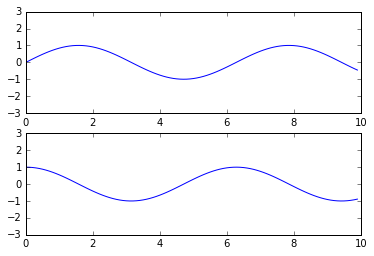

In [48]:
x = np.arange(0., 10., 0.1)
s = np.sin(x)
c = np.cos(x)

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax1.plot(x, s)
ax1.set_ylim(-3, 3)

ax2 = fig.add_subplot(212)
ax2.plot(x, c)
ax2.set_ylim(-3, 3)

plt.show()

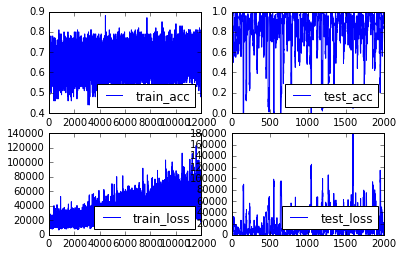

In [55]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(len(train_acc)), train_acc)
ax1.legend(["train_acc"],loc=4)
#ax1.title("Accuracy of digit recognition.")

ax2 = fig.add_subplot(222)
ax2.plot(range(len(test_acc)), test_acc)
ax2.legend(["test_acc"],loc=4)
#ax2.title("Accuracy of digit recognition.")

ax3 = fig.add_subplot(223)
ax3.plot(range(len(train_loss)), train_loss)
ax3.legend(["train_loss"],loc=4)

ax4 = fig.add_subplot(224)
ax4.plot(range(len(test_loss)), test_loss)
ax4.legend(["test_loss"],loc=4)

plt.show()

### 第１層のパラメータw
- variable は data属性でアクセスできる

In [69]:
len(l1_W)

20

In [76]:
l1_W[0].shape # 1回目のW。１画像の28*28=784次元の

(1000, 784)

In [78]:
l1_W[0][0].data

array([  4.58881073e-02,   3.05284485e-02,   6.20475272e-03,
         4.34226245e-02,   4.06472906e-02,  -3.68641429e-02,
         2.50919890e-02,   2.73554260e-03,   6.32315651e-02,
         2.34832540e-02,   3.01669445e-02,   2.00829115e-02,
         4.33002487e-02,   1.34450838e-01,   4.20300141e-02,
         7.50593692e-02,  -3.28634568e-02,   2.05558781e-02,
        -5.89342900e-02,   3.11072520e-03,   7.07780570e-02,
         1.03927925e-02,   4.85045463e-02,   4.28035334e-02,
         2.54741702e-02,  -4.03687246e-02,  -7.58694485e-03,
        -1.17593147e-02,   5.32607315e-03,   3.10919471e-02,
        -3.31466049e-02,   3.73200551e-02,  -2.98526436e-02,
         9.98814404e-02,   2.26946250e-01,   2.94337004e-01,
         2.97572464e-01,   4.47808474e-01,   5.09930372e-01,
         5.26342750e-01,   7.90252864e-01,   8.53332162e-01,
         9.19110119e-01,   7.94267416e-01,   9.03237879e-01,
         7.11398363e-01,   5.88563085e-01,   4.88533914e-01,
         4.31283563e-01,

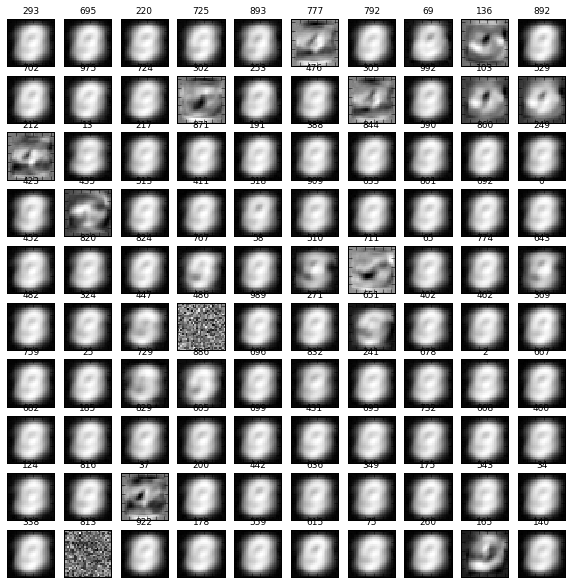

In [79]:
def draw_digit2(data, n, i):
    size = 28
    plt.subplot(10, 10, n)
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(Z)
    plt.title("%d"%i, size=9)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

plt.figure(figsize=(10,10))
cnt = 1
for i in np.random.permutation(1000)[:100]:
    draw_digit2(l1_W[len(l1_W)-1][i].data, cnt, i)
    cnt += 1

plt.show()

### chainer 1.11 のやり方は以下、まだおえてない

In [37]:
# Set up a trainer
updater = training.StandardUpdater(train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, (epoch, 'epoch'), out=out)

NameError: name 'out' is not defined

In [ ]:

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args.gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot at each epoch
    trainer.extend(extensions.snapshot(), trigger=(args.epoch, 'epoch'))

    # Write a log of evaluation statistics for each epoch
    trainer.extend(extensions.LogReport())

    # Print selected entries of the log to stdout
    # Here "main" refers to the target link of the "main" optimizer again, and
    # "validation" refers to the default name of the Evaluator extension.
    # Entries other than 'epoch' are reported by the Classifier link, called by
    # either the updater or the evaluator.
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy']))

    # Print a progress bar to stdout
    trainer.extend(extensions.ProgressBar())

    if args.resume:
        # Resume from a snapshot
        chainer.serializers.load_npz(args.resume, trainer)

    # Run the training
    trainer.run()